# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

### Contents:
- [Background](#Background)
- [Data](#Data)
- [Building own models](#Building-own-models)
- [Evaluate results](#Evaluate-results)



In [1]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img, load_img, img_to_array
from tensorflow.keras.models import Sequential,  Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Average, Input, Activation, Reshape, TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
pd.options.mode.chained_assignment = None  # default='warn'



**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

**import data and get labels**

In [2]:
train_path = '../data/train/'
valid_path = '../data/valid/'

In [3]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['axial', 'coronal', 'sagittal']
# diagnosis = ['abnormal','meniscus','acl']

In [47]:
def get_data(dataset_type, plane, diagnosis):
    '''this function gets the data from the original dataset'''
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
        
#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)
    
    label_path = f'../data/{dataset_type}-{diagnosis}.csv'
#     label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, plane_dir, label_data)

**meniscus dataset**

In [5]:
# training data
train_coronal_data, train_coronal_dir, train_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_data, train_axial_dir, train_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_data, train_sagittal_dir, train_men_label = get_data('train', 'sagittal', 'meniscus')

In [6]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_men_label = get_data('valid','coronal','meniscus')
valid_axial_data, valid_axial_dir, valid_men_label = get_data('valid','axial','meniscus')
valid_sagittal_data, valid_sagittal_dir, valid_men_label = get_data('valid','sagittal','meniscus')

In [7]:
train_coronal_data[0]

'0000.npy'

In [8]:
train_coronal_dir

'../data/train//coronal'

The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained. 


In [9]:
def image_extraction(data, path, new_path): #3 images
    '''this function extracts middle 3 slides of each scan'''
    extract=[]
    new_data=[]
    for i in range(len(data)): 
        img = np.load(os.path.join(path,data[i]))
        middle_idx = int(img.shape[0]/2)
#         print(img.shape[0],middle_idx)
        img = img[(middle_idx - 1) : (middle_idx + 2)]
#         # reshape adapted for model (s x 256 x 256 x 1)
#         img_reshape = np.repeat(img[..., np.newaxis], 1, -1)
        img = img.reshape(256,256,3)
        extract.extend(img)
        new_data.append(np.array(extract))        
        extract.clear()
        
#     new_data.shape(1130,256,256,3) for train
#     new_data.shape(120,256,256,3) for valid
    np.save(new_path, np.array(new_data))


**image extraction for training data**

In [10]:
# image extraction for 3 planes
new_path = '../data/train_transform/coronal'
image_extraction(train_coronal_data, train_coronal_dir, new_path)

In [11]:
new_path = '../data/train_transform/axial'
image_extraction(train_axial_data, train_axial_dir, new_path)

In [12]:
new_path = '../data/train_transform/sagittal'
image_extraction(train_sagittal_data, train_sagittal_dir, new_path)

In [13]:
image = np.load('../data/train_transform/sagittal.npy')

In [14]:
image[0].shape

(256, 256, 3)

**extraction for validation data**

In [15]:
# image extraction for 3 planes
new_path = '../data/valid_transform/coronal'
image_extraction(valid_coronal_data, valid_coronal_dir, new_path)

In [16]:
new_path = '../data/valid_transform/axial'
image_extraction(valid_axial_data, valid_axial_dir, new_path)

In [17]:
new_path = '../data/valid_transform/sagittal'
image_extraction(valid_sagittal_data, valid_sagittal_dir, new_path)

In [18]:
image = np.load('../data/valid_transform/sagittal.npy')
image.shape

(120, 256, 256, 3)

**data generation for meniscus**

In [45]:
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data from the extracted datset'''
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = '../data/train_transform/'
    else:
        go = '../data/valid_transform/'
        
    plane_dir = f'{go}/{plane}.npy'
    
    data = np.load(plane_dir)
    label_path = f'../data/{dataset_type}-{diagnosis}.csv'
#     label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, label_data)
    

Note that training data for all planes are the same. Only labels are different.

In [20]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal', 'meniscus')

# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal', 'meniscus')

## Building own model

The code snippet below is the first model, a simple stack of two convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun built in the 1990s for image classification (with the exception of ReLU and smaller) ([LeCun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)). In addition, three fully-connected layers were added, which ends with a single unit and a sigmoid activation, for a binary classification. 
<br>
<br> Since other pretrained models showed that there is tendency to overfit, one can either improve the data or improve the model. Since I am limited by what I can do with the dataset, a simple way is to make the model smaller. I made LeNet even smaller by reducing the number of neurons in the connected layers.
<br>
<br> BatchNormalisation layer was added because it would accelerate the training process, while offering similar classification accuracy. I did not see any 'increase' in training. This could be because BatchNormalisation is highly dependent on having a large batch size, so that it can estimate the mean and variance from just one single batch ([Summers and Dinneen 2020](https://arxiv.org/pdf/1906.03548.pdf)). And for a limited dataset like mine, BatchNormalisation with GroupNormalisation was found to have a bigger improvement, or using InstanceNormalisation would be more effective, than just using BatchNormalisation ([Summers and Dinneen 2020](https://arxiv.org/pdf/1906.03548.pdf); [Kolarik et al., 2020](https://arxiv.org/pdf/2011.11559.pdf)). However, GroupNormalisation and InstanceNormalisation were not used here (due to failure to install Tensorflow version, Tensorflow-Addon version and downgrading numpy at the same time).
<br>
<br> In any case, regularizer should NOT be added if normalisation is being used. This is because the use of both normalisation (whether it be batch normalisation, layer normalisation or weight normalisation) together with regularisation has no effect on regularising the network ([Laarhoven 2017](https://arxiv.org/pdf/1706.05350.pdf)). The effect it has is the effective learning rate (which may or may not be a bad thing). However, in such a case, one does not have control over the learning rate (which is problematic for someone with control issues, like me). BatchNormalisation can be useful since it takes the outputs from one layer and normalise it before passing them to the next layer. Furthermore, the tuning of $\gamma$ (scaling to a difference variance) has little effect since $\gamma$ has no functional value in subsequent layers. It is only most effective if used on the last layer of the network. Therefore, BatchNormalisation was used only once in the last convolution layer. 
<br>
<br> To actually control the learning rate of the optimser, sgd with a slow learning rate and momentum was selected based on using AlexNet. 

In [44]:
def build_model():
    '''this function creates and build the cnn model'''
    model = Sequential()
    
    model.add(Conv2D(filters=6, 
                     kernel_size=(5, 5),
                     activation='relu',
                     padding='same',
                     input_shape=(256,256,3)))
    model.add(MaxPooling2D(pool_size=(2,2),
                              strides=(2,2)))

    model.add(Conv2D(filters=16, 
                     kernel_size=(5, 5), 
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),
                              strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    
    sgd = optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 6)       456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 6)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 16)      2416      
_________________________________________________________________
batch_normalization (BatchNo (None, 124, 124, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [23]:
for layer in model.layers:
    layer.trainable = True
df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df.style.applymap(lambda trainable: f'background-color: {"yellow" if trainable else "white"}', subset=['trainable'])

,layer,trainable
0,conv2d,True
1,max_pooling2d,True
2,conv2d_1,True
3,batch_normalization,True
4,max_pooling2d_1,True
5,flatten,True
6,dense,True
7,dropout,True
8,dense_1,True
9,dropout_1,True


In [48]:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# training model that will be added to VGG16
def model_train(model, model_name, num_epochs, train_data, train_labels, validation_data, validation_labels):
    '''this function fits the training data and save the weights and model'''
    path_dir = r'C:\Users\USER\DSI-roughpaper\capstone\data' 
    path = f'{path_dir}\{model_name}\weights.h5'
    checkpoint_path = f'{path_dir}\{model_name}\own_model.h5'

    history = model.fit(x=train_data, y=np.array(train_labels), 
            batch_size=32, 
            validation_data=(validation_data, np.array(validation_labels)),
            epochs=num_epochs, 
            callbacks = [EarlyStopping(patience=2, monitor = 'val_loss', mode = 'min'),
                        ModelCheckpoint(filepath=checkpoint_path, monitor = 'val_loss', save_best_only=True)], 
            verbose=1)

    model.save_weights(path)
    
    return model, history

Batch_size is small at 32, given that previous large numbers resulted in validation accuracy fluctuating up and down. It seems that a larger batch may result in degradation of the quality of the model, since the model lacks the ability to generalise the dataset. 
<br>
<br> The exact amount of patience will vary between models and problems. There a rule of thumb to make it 10% of number of epoch. Patience was kept at 2, since from previous models, overfitting occur very early during training (val_loss > training_loss). So it was better to stop it early, rather than have a higher value for patience. 

In [49]:
def plot_results(model):
    '''this function plots the results of the model'''
    train_loss = model.history['loss']
    test_loss = model.history['val_loss']
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    epoch_labels = model.epoch

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')

    axes[1].plot(acc, label='Training accuracy', color='blue')
    axes[1].plot(val_acc, label='Testing accuracy', color='red')

    # Set title
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Crossentropy')
    axes[1].set_ylabel('Binary Crossentropy')
    plt.xticks(epoch_labels, epoch_labels);    
    axes[0].legend(fontsize=18);
    axes[1].legend(fontsize=18);


**predictions for meniscus dataset**

Epoch 1/10
36/36 [==============================] - 43s 1s/step - loss: 0.8612 - accuracy: 0.5549 - val_loss: 0.7025 - val_accuracy: 0.5583
Epoch 2/10
36/36 [==============================] - 43s 1s/step - loss: 0.7260 - accuracy: 0.5885 - val_loss: 0.6762 - val_accuracy: 0.5500
Epoch 3/10
36/36 [==============================] - 42s 1s/step - loss: 0.6511 - accuracy: 0.6088 - val_loss: 0.6803 - val_accuracy: 0.5167
Epoch 4/10
36/36 [==============================] - 43s 1s/step - loss: 0.6344 - accuracy: 0.6204 - val_loss: 0.7222 - val_accuracy: 0.5167


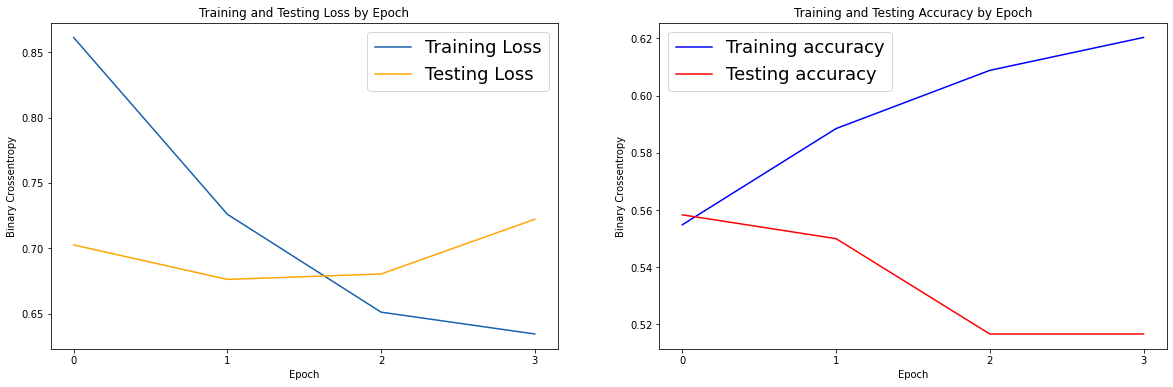

In [26]:
# coronal plane
num_epochs=10

cnn_model = build_model()
cor_men_model, hst_cmen = model_train(cnn_model, 'hst_cmen', num_epochs, coronal_mensicus, coronal_mensicus_label, coronal_mensicus_val, coronal_mensicus_label_val)

# get/plot accuracy
hst_cmen_acc=[]
hst_cmen_acc.append(np.mean(hst_cmen.history['val_accuracy']))
plot_results(hst_cmen)

Epoch 1/10
36/36 [==============================] - 47s 1s/step - loss: 0.8624 - accuracy: 0.5743 - val_loss: 0.7493 - val_accuracy: 0.5583
Epoch 2/10
36/36 [==============================] - 43s 1s/step - loss: 0.6696 - accuracy: 0.5982 - val_loss: 0.6652 - val_accuracy: 0.5750
Epoch 3/10
36/36 [==============================] - 43s 1s/step - loss: 0.6275 - accuracy: 0.6283 - val_loss: 0.6749 - val_accuracy: 0.5583
Epoch 4/10
36/36 [==============================] - 46s 1s/step - loss: 0.6154 - accuracy: 0.6274 - val_loss: 0.6716 - val_accuracy: 0.5417


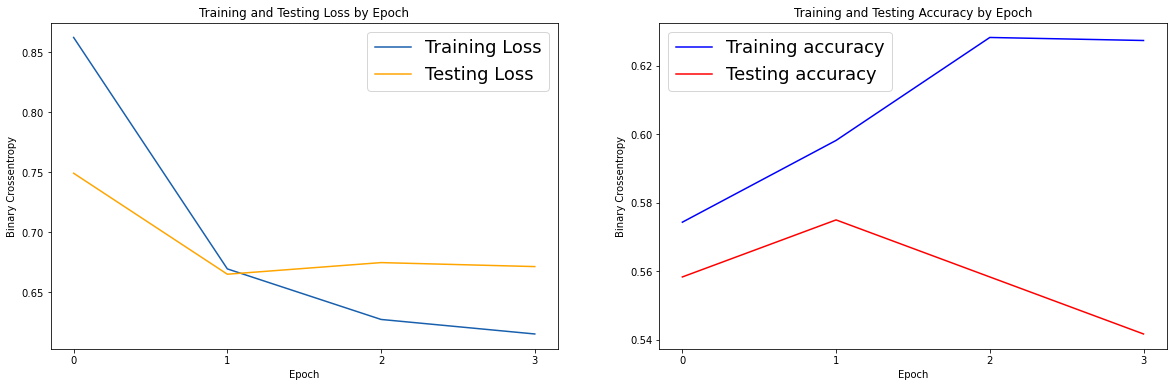

In [27]:
# axial plane
num_epochs=10

cnn_model = build_model()
axl_men_model, hst_amen = model_train(cnn_model, 'hst_amen', num_epochs, axial_mensicus, axial_mensicus_label, axial_mensicus_val, axial_mensicus_label_val)

# get/plot accuracy
hst_amen_acc=[]
hst_amen_acc.append(np.mean(hst_amen.history['val_accuracy']))
plot_results(hst_amen)

Epoch 1/10
36/36 [==============================] - 47s 1s/step - loss: 0.8886 - accuracy: 0.5796 - val_loss: 0.7283 - val_accuracy: 0.5583
Epoch 2/10
36/36 [==============================] - 46s 1s/step - loss: 0.6649 - accuracy: 0.6186 - val_loss: 0.6817 - val_accuracy: 0.5833
Epoch 3/10
36/36 [==============================] - 51s 1s/step - loss: 0.6300 - accuracy: 0.6434 - val_loss: 0.6821 - val_accuracy: 0.5667
Epoch 4/10
36/36 [==============================] - 49s 1s/step - loss: 0.6106 - accuracy: 0.6327 - val_loss: 0.6548 - val_accuracy: 0.5750
Epoch 5/10
36/36 [==============================] - 56s 2s/step - loss: 0.5876 - accuracy: 0.6504 - val_loss: 0.6622 - val_accuracy: 0.5833
Epoch 6/10
36/36 [==============================] - 56s 2s/step - loss: 0.5605 - accuracy: 0.6841 - val_loss: 0.6581 - val_accuracy: 0.6000


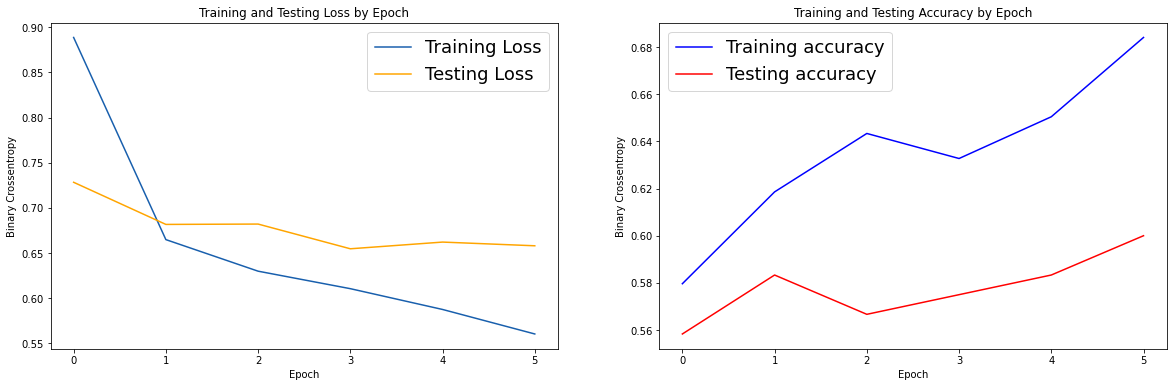

In [28]:
# sagittal plane
num_epochs=10

cnn_model = build_model()
sag_men_model, hst_smen = model_train(cnn_model, 'hst_smen', num_epochs, sagittal_mensicus, sagittal_mensicus_label, sagittal_mensicus_val, sagittal_mensicus_label_val)

# get/plot accuracy
hst_smen_acc=[]
hst_smen_acc.append(np.mean(hst_smen.history['val_accuracy']))
plot_results(hst_smen)

The graphs so far are far from perfect, but it is a big improvement on the overtraining seen in other models.

**calculate average accuracy**

In [29]:
[hst_cmen_acc, hst_amen_acc, hst_smen_acc]

[[0.5354166626930237], [0.5583333373069763], [0.577777773141861]]

## Evaluate results

In [30]:
cmen_scores = cor_men_model.evaluate(coronal_mensicus_val, np.array(coronal_mensicus_label_val), verbose=0)
print('Test loss:', cmen_scores[0]) 
print('Test accuracy:', cmen_scores[1])

Test loss: 0.7221826910972595
Test accuracy: 0.5166666507720947


In [31]:
amen_scores = axl_men_model.evaluate(axial_mensicus_val, np.array(axial_mensicus_label_val), verbose=0)
print('Test loss:', amen_scores[0]) 
print('Test accuracy:', amen_scores[1])

Test loss: 0.6715589761734009
Test accuracy: 0.5416666865348816


In [32]:
smen_scores = sag_men_model.evaluate(sagittal_mensicus_val, np.array(sagittal_mensicus_label_val), verbose=0)
print('Test loss:', smen_scores[0]) 
print('Test accuracy:', smen_scores[1])

Test loss: 0.6580755710601807
Test accuracy: 0.6000000238418579


**Evaluate predictions**

In [33]:
path_dir = r'C:\Users\USER\DSI-roughpaper\capstone\data' 
saved_cor_model = load_model(f'{path_dir}\hst_cmen\men_model.h5')
cor_pred = saved_cor_model.predict(coronal_mensicus_val) 

In [34]:
saved_axl_model = load_model(f'{path_dir}\hst_amen\men_model.h5')
axl_pred = saved_axl_model.predict(axial_mensicus_val) 

In [35]:
saved_sag_model = load_model(f'{path_dir}\hst_smen\men_model.h5')
sag_pred = saved_sag_model.predict(sagittal_mensicus_val) 

In [36]:
pred = pd.DataFrame(np.column_stack([cor_pred,axl_pred,sag_pred]),columns=['cor_pred', 'axl_pred', 'sag_pred'])
pred['mean'] = pred.mean(axis=1)

In [37]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
# take average probability from all 3 planes
pred['mean']

0      0.282040
1      0.294948
2      0.283195
3      0.229338
4      0.494167
         ...   
115    0.501067
116    0.517749
117    0.459579
118    0.498208
119    0.393880
Name: mean, Length: 120, dtype: float32

In [38]:
# if prob<0.5, it is 0.
pred['predict'] = pred['mean'].map(lambda x: 0 if x<0.5 else 1)

In [39]:
pred['predict'].value_counts()

0    93
1    27
Name: predict, dtype: int64

In [40]:
pred['true'] = coronal_mensicus_label_val

In [41]:
pred[pred['true'] != pred['predict']].shape

(47, 6)

In [42]:
pred[pred['true'] != pred['predict']]

,cor_pred,axl_pred,sag_pred,mean,predict,true
5,0.584955,0.451003,0.491228,0.509062,1,0
10,0.501321,0.493044,0.587147,0.527170,1,0
11,0.506369,0.547019,0.496947,0.516778,1,0
14,0.579082,0.519504,0.465399,0.521328,1,0
25,0.561006,0.493044,0.496783,0.516944,1,0
26,0.498107,0.556667,0.490023,0.514933,1,0
32,0.556221,0.549035,0.471482,0.525579,1,0
42,0.510225,0.321511,0.419139,0.416958,0,1
43,0.515810,0.442143,0.450668,0.469540,0,1
44,0.431103,0.448910,0.570996,0.483670,0,1


**export results to csv**

In [43]:
pred.to_csv('../data/pred_men_results.csv')